#### This notebook shows that when dependent censoring occurs, the regular MLE is biased (if assuming independent censoring)

In [33]:
import torch
import torch.optim as optim
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic data (time-to-event and censoring indicator)
np.random.seed(285714)
v_e=4; rho_e=14; v_c=3; rho_c=16
# v_e=3; rho_e=16; v_c=4; rho_c=14

size = 100000
num_epochs = 50000

# Define our Weibull survival model
class WeibullModel(torch.nn.Module):
    def __init__(self):
        super(WeibullModel, self).__init__()
        self.shape = torch.nn.Parameter(torch.tensor(1.0))
        self.scale = torch.nn.Parameter(torch.tensor(1.0))

    def log_likelihood(self, times, event_indicator):
        log_pdf = ((self.shape-1) * torch.log(times / self.scale) 
                   + torch.log(self.shape) - torch.log(self.scale) - 
                   ((times / self.scale) ** self.shape))
        log_sf = -((times / self.scale) ** self.shape)
        return (event_indicator * log_pdf + (1 - event_indicator) * log_sf).sum()

### Generate Weibull Survival Data with Random Censoring and fit maximum likelihood model

In [34]:

times_e = np.random.weibull(v_e, size) * rho_e
times_c = np.random.weibull(v_c, size) * rho_c

event_indicator = (times_c > times_e).astype(int)
times_y = np.minimum(times_e, times_c)

# # Convert numpy data to PyTorch tensors
times_tensor = torch.tensor(times_y, dtype=torch.float32).to(device)
event_indicator_tensor = torch.tensor(event_indicator, dtype=torch.float32).to(device)


model = WeibullModel().to(device)

# Create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the number of epochs and the likelihood threshold
likelihood_threshold = 1e-10

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_likelihood = model.log_likelihood(times_tensor, event_indicator_tensor)
    (-log_likelihood).backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")

    if -log_likelihood.item() < likelihood_threshold:
        break

print(f"Estimated Shape: {model.shape.item()}, Estimated Scale: {model.scale.item()}")

Epoch 0, Log-Likelihood: -1089520.0
Epoch 10000, Log-Likelihood: -178460.65625
Epoch 20000, Log-Likelihood: -178460.65625
Epoch 30000, Log-Likelihood: -178460.65625
Epoch 40000, Log-Likelihood: -178460.65625
Estimated Shape: 4.013899803161621, Estimated Scale: 14.005375862121582


### Generate Dependent Censoring Weibull Data (Clayton Copula)

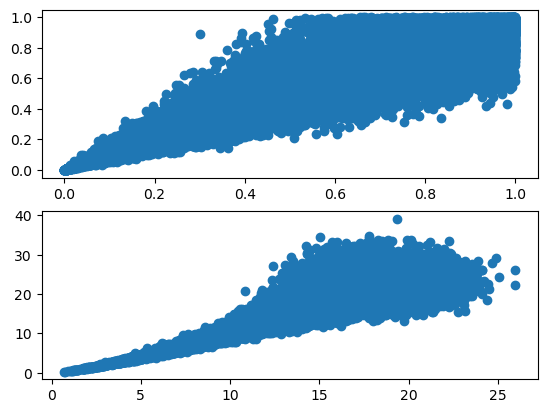

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# define conditional distribution approach  
def clayton_conditional(u,v,theta=5):
    return (u**(-theta)*(v**(-theta/(theta+1))-1)+1)**(-1/theta)

# generate random variable uniformly from 0 to 1
u = np.random.uniform(0, 1, size)
t = np.random.uniform(0, 1, size)

# Now, (u,v) are uniformly distributed in [0,1]^2, and joint CDF is given by the Clayton Copula with parameter theta
v = clayton_conditional(u,t, theta = 10)

plt.subplot(2, 1, 1)
plt.scatter(u, v)

def inverse_transform(u, v, rho):
    return (-np.log(1-u))**(1/v)*rho

event_time = inverse_transform(u, v_e, rho_e)
censoring_time = inverse_transform(v, v_c, rho_c)

plt.subplot(2, 1, 2)
plt.scatter(event_time, censoring_time)

# create observed time 
observed_time = np.minimum(event_time, censoring_time)
event_indicator = (event_time<censoring_time).astype(int)


In [36]:
# # Convert numpy data to PyTorch tensors
times_tensor = torch.tensor(observed_time, dtype=torch.float32).to(device)
event_indicator_tensor = torch.tensor(event_indicator, dtype=torch.float32).to(device)

model2 = WeibullModel().to(device)

# Create an optimizer
optimizer = optim.Adam(model2.parameters(), lr=0.01)

# Define the number of epochs and the likelihood threshold
likelihood_threshold = 1e-10

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_likelihood = model2.log_likelihood(times_tensor, event_indicator_tensor)
    (-log_likelihood).backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")

    if -log_likelihood.item() < likelihood_threshold:
        break

print(f"Estimated Shape: {model2.shape.item()}, Estimated Scale: {model2.scale.item()}")

Epoch 0, Log-Likelihood: -1254222.125
Epoch 10000, Log-Likelihood: -193787.625
Epoch 20000, Log-Likelihood: -193787.625
Epoch 30000, Log-Likelihood: -193787.609375
Epoch 40000, Log-Likelihood: -193787.609375
Estimated Shape: 5.342673301696777, Estimated Scale: 15.147110939025879


In [37]:
# This model still has some problem, not outputting the correct result.

import torch.nn as nn
# Define our Weibull survival model
class WeibullModel_covariates(torch.nn.Module):
    def __init__(self, dim):
        super(WeibullModel_covariates, self).__init__()
        self.shape = torch.nn.Parameter(torch.tensor(1.0))
        self.scale = torch.nn.Parameter(torch.tensor(1.0))
        self.net = nn.Sequential(
            nn.Linear(dim,32),
            nn.Linear(32,1)
        )

    def log_likelihood(self, covariates, times, event_indicator):
        x_beta = self.net(covariates).squeeze()
        log_sf = - ((times / self.scale) ** self.shape * torch.exp(x_beta))
        log_pdf = log_sf + (torch.log(times) - torch.log(self.shape) + x_beta/self.shape)*self.shape \
                                - torch.log(times) + torch.log(self.scale)
        return (event_indicator * log_pdf + (1 - event_indicator) * log_sf).sum()

In [38]:
class WeibullModel_covariates(nn.Module):
    def __init__(self, num_features, hidden_size = 1):
        super(WeibullModel_covariates, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            # nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        self.shape = nn.Parameter(torch.tensor(1.0))
        self.scale = nn.Parameter(torch.tensor(1.0))

    def log_likelihood(self, x, t, c):
        shape_term = torch.log(self.shape)
        x_beta = self.net(x).squeeze()
        log_t_lambda = (self.shape - 1) * torch.log(t / self.scale)
        log_lambda = torch.log(self.scale)
        exp_term = torch.exp(x_beta) * (t / self.scale) ** self.shape

        logL = torch.sum(c * (shape_term + x_beta + log_t_lambda - log_lambda) - exp_term)
        return logL

    def forward(self, t, x, c):
        return -self.log_likelihood(t, x, c)

In [40]:
dim = 1
# generate X from 10 dimensional uniform distribution from 0 to 1
X = np.random.uniform(0, 1, (size, dim))
covariate_tensor = torch.tensor(X, dtype=torch.float32).to(device)

import torch
import torch.optim as optim


# Define our Weibull survival model
model = WeibullModel_covariates(dim).to(device)

# Create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the number of epochs and the likelihood threshold
num_epochs = 50000
likelihood_threshold = 1e-10

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_likelihood = model.log_likelihood(covariate_tensor, times_tensor, event_indicator_tensor)
    (-log_likelihood).backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")

    if -log_likelihood.item() < likelihood_threshold:
        break

print(f"Estimated Shape: {model.shape.item()}, Estimated Scale: {model.scale.item()}")

Epoch 0, Log-Likelihood: -642121.875
Epoch 1000, Log-Likelihood: -211039.9375
Epoch 2000, Log-Likelihood: -195589.890625
Epoch 3000, Log-Likelihood: -193856.9375
Epoch 4000, Log-Likelihood: -193787.46875
Epoch 5000, Log-Likelihood: -193787.09375
Epoch 6000, Log-Likelihood: -193787.0625
Epoch 7000, Log-Likelihood: -193787.0625
Epoch 8000, Log-Likelihood: -193787.0625
Epoch 9000, Log-Likelihood: -193787.109375
Epoch 10000, Log-Likelihood: -193787.0625
Epoch 11000, Log-Likelihood: -193787.078125
Epoch 12000, Log-Likelihood: -193787.046875
Epoch 13000, Log-Likelihood: -193787.0625
Epoch 14000, Log-Likelihood: -193787.109375
Epoch 15000, Log-Likelihood: -193787.0625
Epoch 16000, Log-Likelihood: -193787.078125
Epoch 17000, Log-Likelihood: -193787.0625
Epoch 18000, Log-Likelihood: -193787.546875
Epoch 19000, Log-Likelihood: -193787.09375
Epoch 20000, Log-Likelihood: -193787.15625
Epoch 21000, Log-Likelihood: -193791.15625
Epoch 22000, Log-Likelihood: -193787.09375
Epoch 23000, Log-Likelihood: